In [1]:
import torch
import math
import torch.nn.functional as F
from torch.nn.modules import Module
from torch.nn.parameter import Parameter
from torch.nn.modules.utils import _pair as pair
from torch.autograd import Variable
from torch.nn import init

In [2]:
limit_a, limit_b, epsilon = -.1, 1.1, 1e-6

In [68]:
class L0Dense(Module):
    """Implementation of L0 regularization for the input units of a fully connected layer"""
    def __init__(self, in_features, out_features, bias=True, weight_decay=1., droprate_init=0.5, temperature=2./3.,
                 lamba=1., local_rep=False, **kwargs):
        """
        :param in_features: Input dimensionality
        :param out_features: Output dimensionality
        :param bias: Whether we use a bias
        :param weight_decay: Strength of the L2 penalty
        :param droprate_init: Dropout rate that the L0 gates will be initialized to
        :param temperature: Temperature of the concrete distribution
        :param lamba: Strength of the L0 penalty
        :param local_rep: Whether we will use a separate gate sample per element in the minibatch
        """
        super(L0Dense, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_prec = weight_decay
        self.weights = Parameter(torch.Tensor(in_features, out_features))
        self.qz_loga = Parameter(torch.Tensor(in_features))
        self.temperature = temperature
        self.droprate_init = droprate_init if droprate_init != 0. else 0.5
        self.lamba = lamba
        self.use_bias = False
        self.local_rep = local_rep
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
            self.use_bias = True
        self.floatTensor = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
        self.reset_parameters()
        print(self)

    def reset_parameters(self):
        init.kaiming_normal_(self.weights, mode='fan_out')

        self.qz_loga.data.normal_(math.log(1 - self.droprate_init) - math.log(self.droprate_init), 1e-2)

        if self.use_bias:
            self.bias.data.fill_(0)

    def constrain_parameters(self, **kwargs):
        self.qz_loga.data.clamp_(min=math.log(1e-2), max=math.log(1e2))

    def cdf_qz(self, x):
        """Implements the CDF of the 'stretched' concrete distribution"""
        xn = (x - limit_a) / (limit_b - limit_a)
        logits = math.log(xn) - math.log(1 - xn)
        return F.sigmoid(logits * self.temperature - self.qz_loga).clamp(min=epsilon, max=1 - epsilon)

    def quantile_concrete(self, x):
        """Implements the quantile, aka inverse CDF, of the 'stretched' concrete distribution"""
        y = F.sigmoid((torch.log(x) - torch.log(1 - x) + self.qz_loga) / self.temperature)
        return y * (limit_b - limit_a) + limit_a

    def _reg_w(self):
        """Expected L0 norm under the stochastic gates, takes into account and re-weights also a potential L2 penalty"""
        logpw_col = torch.sum(- (.5 * self.prior_prec * self.weights.pow(2)) - self.lamba, 1)
        logpw = torch.sum((1 - self.cdf_qz(0)) * logpw_col)
        logpb = 0 if not self.use_bias else - torch.sum(.5 * self.prior_prec * self.bias.pow(2))
        return logpw + logpb

    def regularization(self):
        return self._reg_w()

    def count_expected_flops_and_l0(self):
        """Measures the expected floating point operations (FLOPs) and the expected L0 norm"""
        # dim_in multiplications and dim_in - 1 additions for each output neuron for the weights
        # + the bias addition for each neuron
        # total_flops = (2 * in_features - 1) * out_features + out_features
        ppos = torch.sum(1 - self.cdf_qz(0))
        expected_flops = (2 * ppos - 1) * self.out_features
        expected_l0 = ppos * self.out_features
        if self.use_bias:
            expected_flops += self.out_features
            expected_l0 += self.out_features
        return expected_flops.data[0], expected_l0.data[0]

    def get_eps(self, size):
        """Uniform random numbers for the concrete distribution"""
        eps = self.floatTensor(size).uniform_(epsilon, 1-epsilon)
        eps = Variable(eps)
        return eps

    def sample_z(self, batch_size, sample=True):
        """Sample the hard-concrete gates for training and use a deterministic value for testing"""
        if sample:
            eps = self.get_eps(self.floatTensor(batch_size, self.in_features))
            z = self.quantile_concrete(eps)
            return F.hardtanh(z, min_val=0, max_val=1)
        else:  # mode
            pi = F.sigmoid(self.qz_loga).view(1, self.in_features).expand(batch_size, self.in_features)
            return F.hardtanh(pi * (limit_b - limit_a) + limit_a, min_val=0, max_val=1)

    def sample_weights(self):
        z = self.quantile_concrete(self.get_eps(self.floatTensor(self.in_features)))
        mask = F.hardtanh(z, min_val=0, max_val=1)
        return mask.view(self.in_features, 1) * self.weights

    def forward(self, input):
        if self.local_rep or not self.training:
            z = self.sample_z(input.size(0), sample=self.training)
            xin = input.mul(z)
            output = xin.mm(self.weights)
        else:
            weights = self.sample_weights()
            output = input.mm(weights)
        if self.use_bias:
            output.add_(self.bias)
        return output

    def __repr__(self):
        s = ('{name}({in_features} -> {out_features}, droprate_init={droprate_init}, '
             'lamba={lamba}, temperature={temperature}, weight_decay={prior_prec}, '
             'local_rep={local_rep}')
        if not self.use_bias:
            s += ', bias=False'
        s += ')'
        return s.format(name=self.__class__.__name__, **self.__dict__)
    

In [ ]:
class simple(Module):
    def __init__(self, in_features, out_features):
        self.linear_layer = torch.nn.linear_layer()

In [409]:
N = 10000
feature1 = torch.randn((N, 1))
feature2 = torch.randn((N, 1))
y = feature1 + 0.5 * feature2 + torch.randn((N, 1)) * 1

In [410]:
torch.corrcoef(torch.concat([feature2, y], dim=1).T)

tensor([[1.0000, 0.3297],
        [0.3297, 1.0000]])

In [411]:
torch.cov(torch.concat([feature2, y], dim=1).T)

tensor([[1.0166, 0.4998],
        [0.4998, 2.2603]])

In [412]:
torch.cov(torch.concat([feature1, y], dim=1).T)

tensor([[1.0055, 1.0136],
        [1.0136, 2.2603]])

In [388]:
model = torch.nn.Linear(2, 1)

In [413]:
input_x = torch.concat([feature1, feature2], dim=1)

In [354]:
def train(input_x, y, model, criterion, optimizer):
    optimizer.zero_grad()
    y_pred = model(input_x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    return loss.item()
        

In [414]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [415]:
list(model.named_parameters())

[('weight',
  Parameter containing:
  tensor([[0.7064, 0.4678]], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([0.0081], requires_grad=True))]

In [416]:
losses = []
for epoch in range(1000):
    loss = train(input_x, y, model, criterion, optimizer)
    losses.append(loss)
    

In [356]:
import matplotlib.pyplot as plt

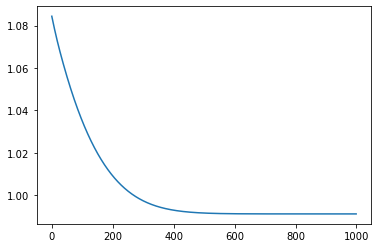

In [417]:
plt.plot(range(len(losses)), losses)

In [418]:
list(model.named_parameters())

[('weight',
  Parameter containing:
  tensor([[1.0087, 0.4931]], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0175], requires_grad=True))]